##  使用BP和RBF神经网络构建流失预测模型，并通过验证数据集的ROC值比较与逻辑回归模型的优劣。


In [1]:
#在分析中，注意区分训练集和验证集。


#在"teleco.csv"中保存有客户流失的数据，其中每个变量的含义如下：
#region  所在区域
#tenure  电信客户年限
#age	年龄
#marital	是否已婚
#address	在当前地址待的年数
#income	家庭收入（单位：千）
#ed	教育水平
#employ	在目前公司的雇佣年限
#retire	是否退休
#gender	性别
#reside	家庭成员数
#tollfree	是否免电话费
#equip	是否租借设备
#callcard	是否使用电话卡服务
#wireless	是否使用无线接入服务
#longmon	上月长途费用
#tollmon	上月免电话费用
#equipmon	上月租借设备费用
#cardmon	上月使用电话卡服务费用
#wiremon	上月使用无线接入服务费用
#longten	长途保有期
#tollten	免电话费保有期
#equipten	租借设备保有期
#cardten	电话卡服务保有期
#wireten	无线服务保有期
#multline	是否多行
#voice	是否使用语音
#pager	是否开通传呼功能
#internet	是否使用网络
#callwait	是否支持呼叫等待
#forward	是否支持转接
#confer	是否开通电话会议
#ebill	是否支持电子凭证
#lninc	电信消费
#custcat	客户类型（客户接受的服务类型）
#churn	是否流失

teleco<-read.csv("data/teleco.csv",fileEncoding="GBK")

head(teleco)

region,tenure,age,marital,address,income,ed,employ,retire,gender,⋯,voice,pager,internet,callwait,forward,confer,ebill,lninc,custcat,churn
Zone 2,13,44,Married,9,64.00,College degree,5,No,Male,⋯,No,No,No,No,Yes,No,No,4.16,Basic service,Yes
Zone 3,11,33,Married,7,136.00,Post-undergraduate degree,5,No,Male,⋯,Yes,Yes,No,Yes,Yes,Yes,No,4.91,Total service,Yes
Zone 3,68,52,Married,24,116.00,Did not complete high school,29,No,Female,⋯,No,No,No,Yes,No,Yes,No,4.75,Plus service,No
Zone 2,33,33,Unmarried,12,33.00,High school degree,0,No,Female,⋯,No,No,No,No,No,No,No,3.50,Basic service,Yes
Zone 2,23,30,Married,9,30.00,Did not complete high school,2,No,Male,⋯,No,No,No,No,Yes,Yes,No,3.40,Plus service,No
Zone 2,41,39,Unmarried,17,78.00,High school degree,16,No,Female,⋯,No,No,No,Yes,No,No,No,4.36,Plus service,No


In [2]:
x_cols<-c("retire","multline","voice","pager","internet","callwait","forward","confer","ebill")

y_col<-c("churn")

teleco<-teleco[,c(x_cols,y_col)]



for(x_col in c(x_cols,y_col) ){
    teleco[,paste0(x_col,"_ind")]<- ifelse(teleco[,x_col]=="Yes",1,0)
}

x_cols<-paste0(x_cols,"_ind")


y_col<-paste0(y_col,"_ind")

teleco<-teleco[,c(x_cols,y_col)]

head(teleco)

table(teleco$churn_ind)

retire_ind,multline_ind,voice_ind,pager_ind,internet_ind,callwait_ind,forward_ind,confer_ind,ebill_ind,churn_ind
0,0,0,0,0,0,1,0,0,1
0,0,1,1,0,1,1,1,0,1
0,0,0,0,0,1,0,1,0,0
0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,1,1,0,0
0,0,0,0,0,1,0,0,0,0



  0   1 
726 274 

In [3]:
library(nnet)
library(ROCR)


Network<-function(maxNum,formula,sizeNum,DataSet,ycol,samplerate){
  
  set.seed(10)
  select<-sample(1:nrow(DataSet),ceiling(nrow(DataSet)*samplerate))
  train<-DataSet[select,]
  test<-DataSet[-select,]
  #进行中心标准化
  cols<-colnames(train)
  xcols<-cols[which(cols!=ycol)]
  train[,xcols]<-scale(train[,xcols])
  test[,xcols]<-scale(test[,xcols])
  

    
  ROC<-data.frame()
  for (i in seq(from =1,to =sizeNum+1,by =1)){
    model_nnet<-nnet(formula, linout = F,size = i, decay = 0.01, maxit = maxNum,trace = F,data = train) 
    train$lg_nnet_p<-predict(model_nnet, train) 
    test$lg_nnet_p<-predict(model_nnet, test) 
    pred_nnet_Tr <- prediction(train$lg_nnet_p, train[,ycol])
    perf_nnet_Tr <- performance(pred_nnet_Tr,"tpr","fpr")
    pred_nnet_Te <- prediction(test$lg_nnet_p, test[,ycol])
    perf_nnet_Te <- performance(pred_nnet_Te,"tpr","fpr")
    lr_m_auc_Tr<-round(as.numeric(performance(pred_nnet_Tr,'auc')@y.values),3)
    lr_m_auc_Te<-round(as.numeric(performance(pred_nnet_Te,'auc')@y.values),3)
    out<-data.frame(i,lr_m_auc_Tr,lr_m_auc_Te)
    ROC<-rbind(ROC,out)
  }  
  return(ROC)
}


Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [4]:
library(ROCR)
ROC <- function(trainpred,testpred,train_y,test_y) { 

  pred_nnet_Tr <- prediction(trainpred, train_y)
  perf_nnet_Tr <- performance(pred_nnet_Tr,"tpr","fpr")
  
  pred_nnet_Te <- prediction(testpred, test_y)
  perf_nnet_Te <- performance(pred_nnet_Te,"tpr","fpr")
  
  plot(perf_nnet_Tr,col='green',main="ROC of Models")
  plot(perf_nnet_Te, col='black',lty=2,add=TRUE);
  abline(0,1,lty=2,col='red')
  
  
  lr_m_auc<-round(as.numeric(performance(pred_nnet_Tr,'auc')@y.values),3)
  lr_m_str<-paste("Tran-AUC:",lr_m_auc,sep="")
  legend(0.3,0.45,c(lr_m_str),2:8)
  
  lr_m_auc<-round(as.numeric(performance(pred_nnet_Te,'auc')@y.values),3)
  lr_m_ste<-paste("Test-AUC:",lr_m_auc,sep="")
  legend(0.3,0.25,c(lr_m_ste),2:8)
}

In [5]:

Roc <- Network(maxNum = 100,formula = churn_ind~.,sizeNum = 10,DataSet = teleco,ycol = y_col,samplerate = 0.7)
names(Roc)<-c("size","Index_Train","Index_Test")
Roc

size,Index_Train,Index_Test
1,0.705,0.752
2,0.739,0.719
3,0.771,0.696
4,0.808,0.676
5,0.816,0.650
6,0.827,0.644
7,0.832,0.633
8,0.833,0.630
9,0.832,0.613
10,0.834,0.590


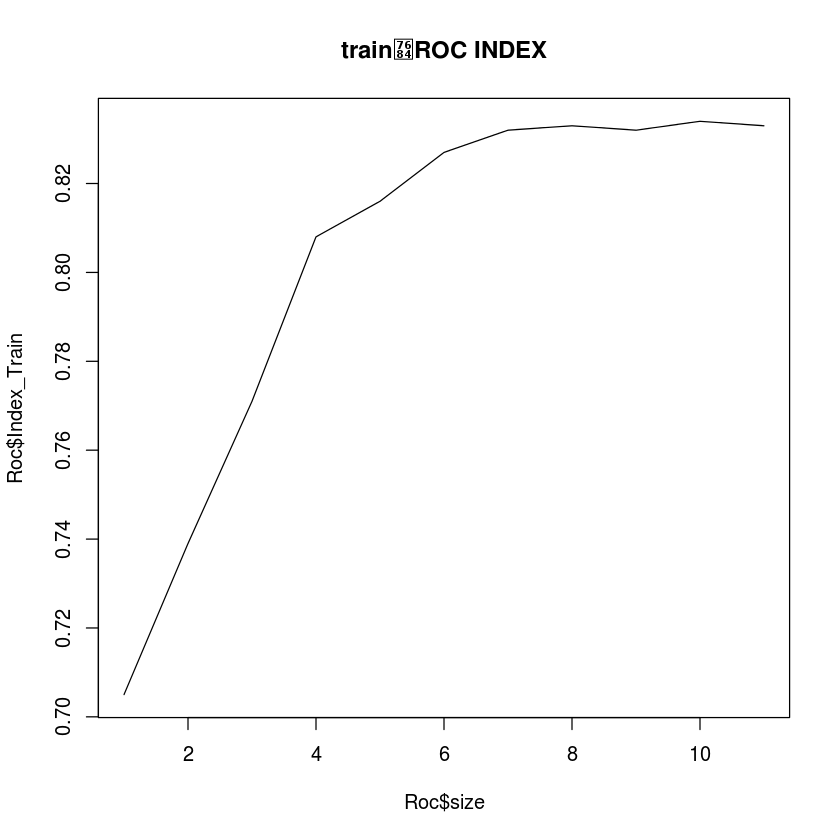

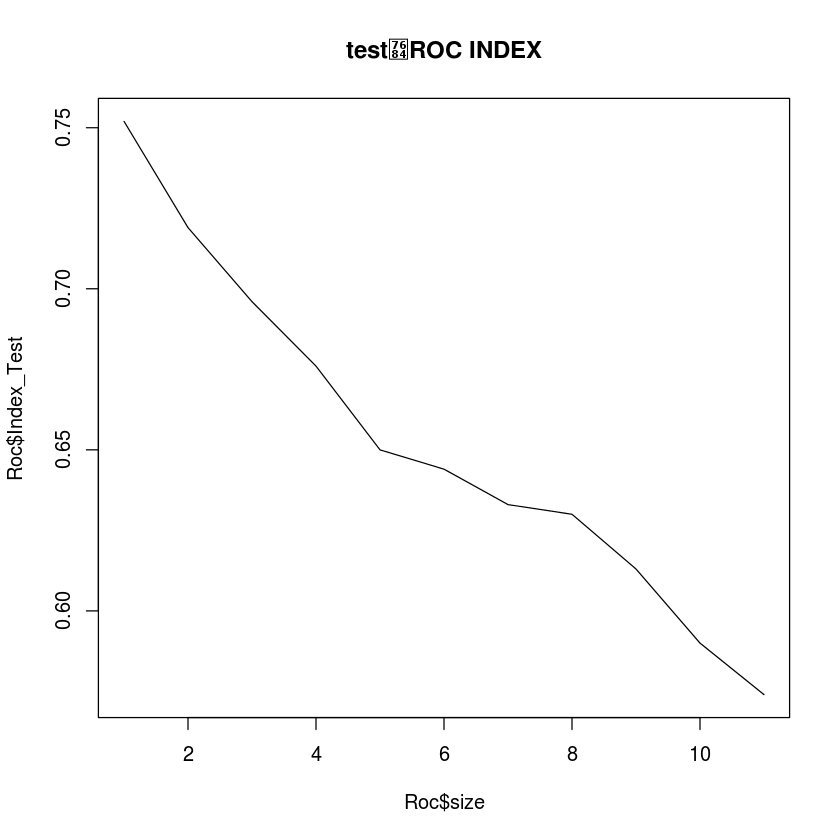

In [6]:
plot(Roc$size,Roc$Index_Train,type="l",main="train的ROC INDEX")
plot(Roc$size,Roc$Index_Test,type="l",main="test的ROC INDEX")

In [12]:
set.seed(10)
  select<-sample(1:nrow(teleco),ceiling(nrow(teleco)*0.7))
  train<-teleco[select,]
  test<-teleco[-select,]

 #进行中心标准化
  cols<-colnames(train)
  xcols<-cols[which(cols!=y_col)]
  train[,xcols]<-scale(train[,xcols])
  test[,xcols]<-scale(test[,xcols])


In [13]:
model_bp<-nnet(churn_ind~., linout = F,size = 2, decay = 0.01, maxit = 100,trace = F,data = train) 

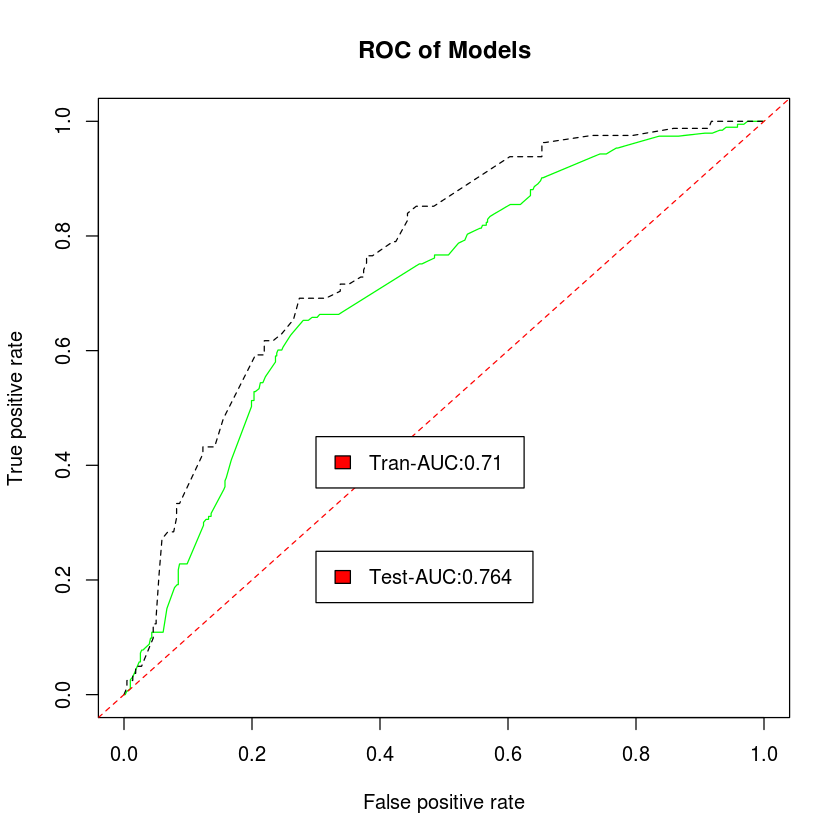

In [14]:
train_pred<-predict(model_bp, train[,x_cols])
test_pred<-predict(model_bp, test[,x_cols])

ROC(train_pred,test_pred,train[,y_col],test[,y_col])

In [15]:
library(RSNNS) 
#极差标准化函数
st_range <- function(x) { 
  return((x - min(x)) / (max(x) - min(x)))
}

Loading required package: Rcpp


In [16]:
#随机抽样，建立训练集与测试集
set.seed(10)
select<-sample(1:nrow(teleco),length(teleco[,1])*0.7)
train=teleco[select,]
test=teleco[-select,]

In [17]:
#极差标准化数据
train[,x_cols]<- as.data.frame(lapply(train[,x_cols], st_range))
test[,x_cols]<- as.data.frame(lapply(test[,x_cols], st_range))

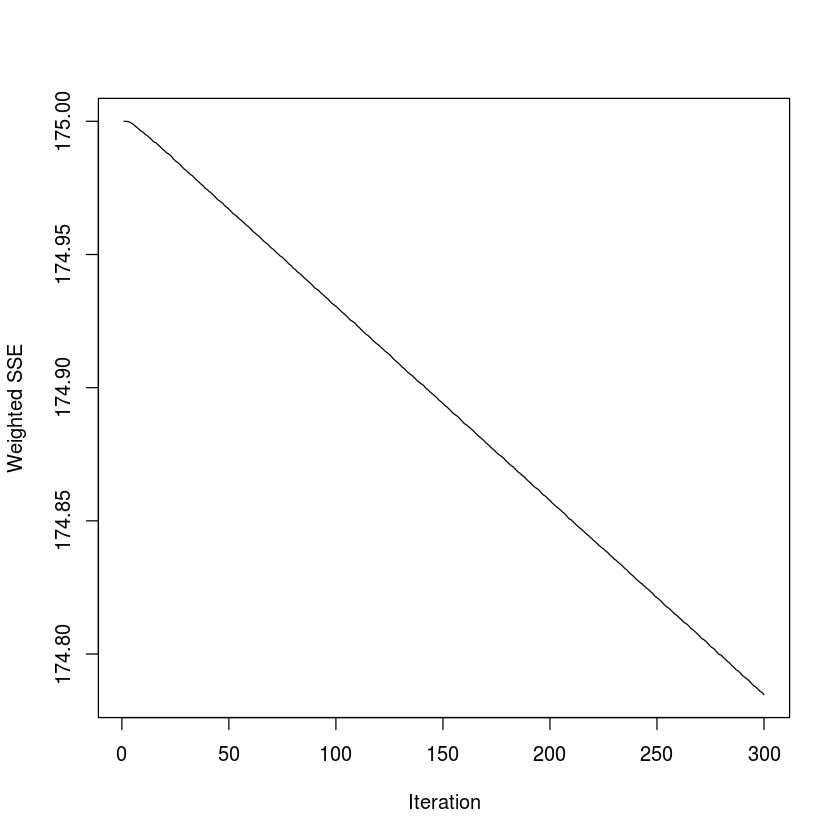

In [22]:
model <- rbf(train[,x_cols], train[,y_col], size=100, maxit=300,linOut=F,
             initFunc = "RBF_Weights",
             initFuncParams=c(-4, 4, 150, 0.6, 0),
             learnFuncParams=c(1e-8, 0, 1e-8, 0.1, 0.8))

plotIterativeError(model)

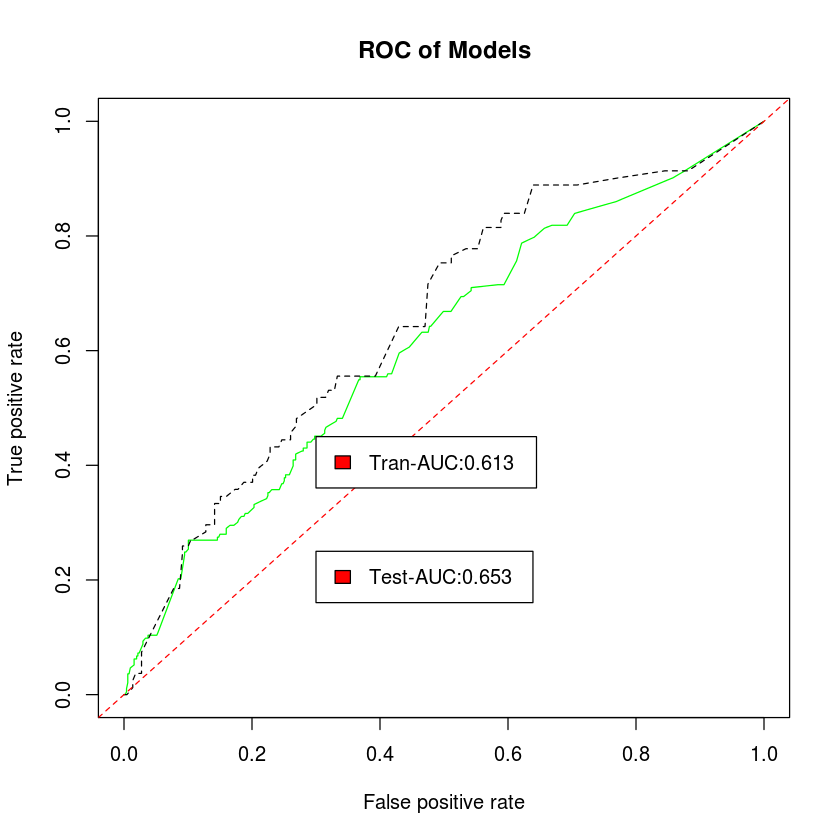

In [23]:
train_pred<-predict(model, train[,x_cols])
test_pred<-predict(model, test[,x_cols])

ROC(train_pred,test_pred,train[,y_col],test[,y_col])